Github link: https://github.com/isabelleantaran/GSB-544-Projects/tree/main/lab

In [3]:
import pandas as pd
import numpy as np
import re 
import requests
from bs4 import BeautifulSoup
import plotnine as p9
from calendar import day_name

# 1. Data from unstructured websites

1. Day of the Week
2. Name of the Recipe
3. Link to Recipe
4. Price of Recipe

In [4]:
url = "https://tastesbetterfromscratch.com/meal-plan-192/"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"
}

In [5]:
response = requests.get(url, headers=headers, timeout=30)
response.raise_for_status()

soup = BeautifulSoup(response.text, 'html.parser')

In [62]:
# Find days and prices
day_pattern = re.compile(r"^(Monday|Tuesday|Wednesday|Thursday|Friday)\s*:", re.IGNORECASE)
price_pattern = re.compile(r"\$[\d]+\.[\d]{2}")

rows = []

# Search through all elements
for element in soup.find_all():
    text = element.get_text(" ", strip=True)
    
    # Check if the element contains a day of the week
    day_match = day_pattern.search(text)
    if not day_match:
        continue
    
    day = day_match.group(1).title()
    
    a = element.find("a")
    if not a:
        parent = element.parent
        if parent:
            a = parent.find("a")
    
    if not a:
        continue
    
    recipe_name = a.get_text(strip=True)
    recipe_url = a.get("href") or None
    
    # Find the price 
    price_match = price_pattern.search(text)
    if not price_match:
        parent = element.parent
        if parent:
            parent_text = parent.get_text(" ", strip=True)
            price_match = price_pattern.search(parent_text)
    
    price = price_match.group(0) if price_match else None
    
    if day and recipe_name and recipe_url:
        rows.append({
            "Day of the Week": day,
            "Name of Recipe": recipe_name,
            "Link to Recipe": recipe_url,
            "Price of Recipe": price
        })

In [7]:
# Remove duplicates (for same meal multiple times)
seen = set()
unique_rows = []
for row in rows:
    key = (row["Day of the Week"], row["Name of Recipe"])
    if key not in seen:
        seen.add(key)
        unique_rows.append(row)

rows = unique_rows

In [63]:
# Sort rows by weekday 
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
order_dict = {d: i for i, d in enumerate(day_order)}
rows = sorted(rows, key=lambda r: order_dict.get(r["Day of the Week"], 99))

In [64]:
# Create DataFrame
df_plan = pd.DataFrame(rows, columns=["Day of the Week", "Name of Recipe", "Link to Recipe", "Price of Recipe"])

# Display the table
display(df_plan)

# Display df info
print("\nDataFrame Information:")
df_plan.info()

,Day of the Week,Name of Recipe,Link to Recipe,Price of Recipe
0,Monday,Pork Carnitas,https://tastesbetterfromscratch.com/slow-cooke...,$17.98
1,Monday,Pork Carnitas,https://tastesbetterfromscratch.com/slow-cooke...,$17.98
2,Monday,Pork Carnitas,https://tastesbetterfromscratch.com/slow-cooke...,$17.98
3,Tuesday,Honey Mustard Chicken Salad,https://tastesbetterfromscratch.com/crusted-ho...,$12.38
4,Wednesday,Garlic Chicken,https://tastesbetterfromscratch.com/chicken-wi...,$11.32
5,Wednesday,Garlic Chicken,https://tastesbetterfromscratch.com/chicken-wi...,$11.32
6,Thursday,Drunken Noodles,https://tastesbetterfromscratch.com/drunken-no...,$12.67
7,Thursday,Drunken Noodles,https://tastesbetterfromscratch.com/drunken-no...,$12.67
8,Friday,Cottage Pie,https://tastesbetterfromscratch.com/cottage-pie/,$20.70
9,Friday,Cottage Pie,https://tastesbetterfromscratch.com/cottage-pie/,$20.70



DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Day of the Week  10 non-null     object
 1   Name of Recipe   10 non-null     object
 2   Link to Recipe   10 non-null     object
 3   Price of Recipe  10 non-null     object
dtypes: object(4)
memory usage: 452.0+ bytes


# 2. Data from an API

Using the Tasty API from the practice activity, search for recipes that match the “Monday” recipe in your meal plan. Compile a table of all these recipes.

In [65]:
api_key = "71443326damsh9b81b08c125e311p1aa88cjsn89e6721ad385"
url = "https://tasty.p.rapidapi.com/recipes/list"
   
headers = {
       "X-RapidAPI-Key": '71443326damsh9b81b08c125e311p1aa88cjsn89e6721ad385', 
       "X-RapidAPI-Host": "tasty.p.rapidapi.com"
   }

In [66]:
def fetch_recipes(search_term, result_limit=100):
    """Fetch recipes from Tasty API"""
    url_tasty = "https://tasty.p.rapidapi.com/recipes/list"
    request_headers = {
        "X-RapidAPI-Key": "71443326damsh9b81b08c125e311p1aa88cjsn89e6721ad385",
        "X-RapidAPI-Host": "tasty.p.rapidapi.com"
    }
    
    params = {
        "from": "0", 
        "size": str(min(result_limit, 100)), 
        "q": search_term
    }
    
    response = requests.get(url_tasty, headers=request_headers, params=params, timeout=30)
    return response


In [ ]:
def sanitize_search_query(text: str) -> str:
    """Remove special characters and normalize whitespace"""
    import re
    text = re.sub(r"[^A-Za-z0-9\s]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

# Get Monday's recipe from meal plan
monday_meals = df_plan[df_plan["Day of the Week"].str.lower() == "monday"]
if monday_meals.empty:
    print("No Monday meals found in df_plan")
    raise SystemExit

target_recipe = monday_meals.iloc[0]["Name of Recipe"]

# Search queries
exact_query = target_recipe
sanitized_query = sanitize_search_query(target_recipe)
significant_words = [word for word in sanitized_query.split() if len(word) > 3]
broad_query = " ".join(significant_words) if significant_words else sanitized_query

query_list = [exact_query, sanitized_query]
if broad_query not in query_list:
    query_list.append(broad_query)

# Fetch and parse recipe data
recipe_data = []
found_recipes = False

for search_query in query_list:
    print(f"  Trying query: '{search_query}'")
    
    try:
        response = fetch_recipes(search_query, result_limit=100)
        recipe_results = response.json().get("results", [])
        print(f"    Found {len(recipe_results)} results")
        
        if len(recipe_results) == 0:
            continue  
        
        for recipe in recipe_results:
            nutritional_info = recipe.get("nutrition") or {}
            user_ratings = recipe.get("user_ratings") or {}
            recipe_slug = recipe.get("slug")
            
            recipe_data.append({
                "QueryUsed": search_query,
                "Day of the Week": "Monday",
                "Mealplan Recipe": target_recipe,
                "Tasty Recipe Name": recipe.get("name"),
                "Tasty URL": f"https://tasty.co/recipe/{recipe_slug}" if recipe_slug else None,
                "Calories": nutritional_info.get("calories"),
                "Protein_g": nutritional_info.get("protein"),
                "Fat_g": nutritional_info.get("fat"),
                "Carbs_g": nutritional_info.get("carbohydrates"),
                "Sugar_g": nutritional_info.get("sugar"),
                "Fiber_g": nutritional_info.get("fiber"),
                "UserRatingScore": user_ratings.get("score") if isinstance(user_ratings, dict) else None
            })
        
        found_recipes = True
        break 
        
    except Exception as e:
        print(f"    Error: {e}")
        continue

# If no recipes found, create empty row 
if not found_recipes:
    print(f"\n No recipes found for '{target_recipe}'")
    recipe_data.append({
        "QueryUsed": exact_query,
        "Day of the Week": "Monday",
        "Mealplan Recipe": target_recipe,
        "Tasty Recipe Name": None,
        "Tasty URL": None,
        "Calories": None,
        "Protein_g": None,
        "Fat_g": None,
        "Carbs_g": None,
        "Sugar_g": None,
        "Fiber_g": None,
        "UserRatingScore": None
    })

# Create DataFrame
display(monday_recipes.head(10))

  Trying query: 'Pork Carnitas'
    Found 10 results


,QueryUsed,Day of the Week,Mealplan Recipe,Tasty Recipe Name,Tasty URL,Calories,Protein_g,Fat_g,Carbs_g,Sugar_g,Fiber_g,UserRatingScore
0,Pork Carnitas,Monday,Pork Carnitas,Slow Cooker Carnitas,https://tasty.co/recipe/slow-cooker-carnitas,1023.0,77.0,71.0,9.0,4.0,2.0,0.976678
1,Pork Carnitas,Monday,Pork Carnitas,Mexican Carnitas As Made By Claudette Zepeda,https://tasty.co/recipe/mexican-carnitas-as-ma...,NaN,NaN,NaN,NaN,NaN,NaN,0.886792
2,Pork Carnitas,Monday,Pork Carnitas,Instant Pot Carnitas,https://tasty.co/recipe/instant-pot-carnitas,534.0,39.0,36.0,9.0,6.0,1.0,0.941980
3,Pork Carnitas,Monday,Pork Carnitas,Carnitas Steamed Buns,https://tasty.co/recipe/carnitas-steamed-buns,573.0,36.0,29.0,38.0,3.0,1.0,0.935275
4,Pork Carnitas,Monday,Pork Carnitas,Carnitas Salad,https://tasty.co/recipe/carnitas-salad,984.0,57.0,73.0,26.0,10.0,5.0,0.939394
5,Pork Carnitas,Monday,Pork Carnitas,Carnitas Tostadas With Pineapple Salsa,https://tasty.co/recipe/carnitas-tostadas-with...,1020.0,59.0,63.0,58.0,20.0,10.0,0.812500
6,Pork Carnitas,Monday,Pork Carnitas,Sopes De Carnitas,https://tasty.co/recipe/sopes-de-carnitas,NaN,NaN,NaN,NaN,NaN,NaN,0.642857
7,Pork Carnitas,Monday,Pork Carnitas,Torta Ahogada,https://tasty.co/recipe/torta-ahogada,NaN,NaN,NaN,NaN,NaN,NaN,0.857143
8,Pork Carnitas,Monday,Pork Carnitas,Carnitas For the Carnivores!,https://tasty.co/recipe/carnitas-for-the-carni...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Pork Carnitas,Monday,Pork Carnitas,25 Amazing Dinners From Tasty,https://tasty.co/recipe/25-amazing-dinners-fro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Automate it

In [14]:
def get_weekly_plan(plan_number):
    """Scrape meal plan from website and return DataFrame"""
    HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    URL = f"https://tastesbetterfromscratch.com/meal-plan-{plan_number}/"
    
    resp = requests.get(URL, headers=HEADERS, timeout=30)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")
    
    day_pattern = re.compile(
        r"^(monday|tuesday|wednesday|thursday|friday|saturday|sunday)\W[\s:—-]*",
        re.IGNORECASE
    )
    price_pattern = re.compile(r"\$[\d]+\.[\d]{2}")
    rows = []
    
    container = soup.select_one(".entry-content") or soup
    current_day = None
    
    for el in container.find_all(["p", "li"]):
        text = " ".join(el.get_text(" ", strip=True).split())
        if not text:
            continue
        
        m = day_pattern.match(text)
        if m:
            current_day = m.group(1).title()
            remainder = text[m.end():].strip(" :—-")
            a = el.find("a")
            
            recipe_name = a.get_text(strip=True) if a else (remainder if remainder else None)
            recipe_url = (a.get("href") if a else None) or None
            price_match = price_pattern.search(text)
            price = price_match.group(0) if price_match else None
            
            if recipe_name or recipe_url or price:
                rows.append({
                    "Day of the Week": current_day,
                    "Name of Recipe": recipe_name,
                    "Link to Recipe": recipe_url,
                    "Price of Recipe": price
                })
                current_day = None
                continue
        
        if current_day:
            a = el.find("a")
            if a:
                recipe_name = a.get_text(strip=True)
                recipe_url = a.get("href") or None
                price_match = price_pattern.search(text)
                price = price_match.group(0) if price_match else None
                
                rows.append({
                    "Day of the Week": current_day,
                    "Name of Recipe": recipe_name,
                    "Link to Recipe": recipe_url,
                    "Price of Recipe": price
                })
                current_day = None
    
    from calendar import day_name
    order = {d: i for i, d in enumerate(day_name)}
    rows = sorted(rows, key=lambda r: order.get(r["Day of the Week"], 99))
    
    return pd.DataFrame(rows, columns=[
        "Day of the Week", "Name of Recipe", "Link to Recipe", "Price of Recipe"
    ])

In [15]:
weekly_plan = get_weekly_plan(192)
weekly_plan

,Day of the Week,Name of Recipe,Link to Recipe,Price of Recipe
0,Monday,Pork Carnitas,https://tastesbetterfromscratch.com/slow-cooke...,$17.98
1,Tuesday,Honey Mustard Chicken Salad,https://tastesbetterfromscratch.com/crusted-ho...,$12.38
2,Wednesday,Garlic Chicken,https://tastesbetterfromscratch.com/chicken-wi...,$11.32
3,Thursday,Drunken Noodles,https://tastesbetterfromscratch.com/drunken-no...,$12.67
4,Friday,Cottage Pie,https://tastesbetterfromscratch.com/cottage-pie/,$20.70


In [16]:
def match_recipe(day):
    """Search Tasty API for recipes matching a specific day's meal"""
    day_meals = weekly_plan[weekly_plan["Day of the Week"].str.lower() == day.lower()]
    if day_meals.empty:
        print(f"No {day} meals found in weekly_plan")
        raise SystemExit
    
    target_recipe = day_meals.iloc[0]["Name of Recipe"]
    
    exact_query = target_recipe
    sanitized_query = sanitize_search_query(target_recipe)
    significant_words = [word for word in sanitized_query.split() if len(word) > 3]
    broad_query = " ".join(significant_words) if significant_words else sanitized_query
    fallback_query = significant_words[-1] if significant_words else sanitized_query
    
    query_list = [exact_query, sanitized_query]
    if broad_query not in query_list:
        query_list.append(broad_query)
    if fallback_query not in query_list:
        query_list.append(fallback_query)
    
    recipe_data2 = []
    
    for search_query in query_list:
        response = fetch_recipes(search_query, result_limit=100)
        recipe_results = response.json().get("results", [])
        
        for recipe in recipe_results:
            nutritional_info = recipe.get("nutrition") or {}
            user_ratings = recipe.get("user_ratings") or {}
            recipe_slug = recipe.get("slug")
            
            recipe_data2.append({
                "QueryUsed": search_query,
                "Day of the Week": day.title(),
                "Mealplan Recipe": target_recipe,
                "Tasty Recipe Name": recipe.get("name"),
                "Tasty URL": f"https://tasty.co/recipe/{recipe_slug}" if recipe_slug else None,
                "Calories": nutritional_info.get("calories"),
                "Protein_g": nutritional_info.get("protein"),
                "Fat_g": nutritional_info.get("fat"),
                "Carbs_g": nutritional_info.get("carbohydrates"),
                "Sugar_g": nutritional_info.get("sugar"),
                "Fiber_g": nutritional_info.get("fiber"),
                "UserRatingScore": (user_ratings.get("score") if isinstance(user_ratings, dict) else None)
            })
        
        if recipe_data2:
            break
    
    if not recipe_data2:
        print(f"No matches found for '{target_recipe}' — trying a broad search...")
        broad_response = fetch_recipes(target_recipe.split()[0], result_limit=100)
        recipe_results = broad_response.json().get("results", [])
        for recipe in recipe_results:
            nutritional_info = recipe.get("nutrition") or {}
            user_ratings = recipe.get("user_ratings") or {}
            recipe_slug = recipe.get("slug")
            
            recipe_data2.append({
                "QueryUsed": f"{target_recipe.split()[0]} (fallback)",
                "Day of the Week": day.title(),
                "Mealplan Recipe": target_recipe,
                "Tasty Recipe Name": recipe.get("name"),
                "Tasty URL": f"https://tasty.co/recipe/{recipe_slug}" if recipe_slug else None,
                "Calories": nutritional_info.get("calories"),
                "Protein_g": nutritional_info.get("protein"),
                "Fat_g": nutritional_info.get("fat"),
                "Carbs_g": nutritional_info.get("carbohydrates"),
                "Sugar_g": nutritional_info.get("sugar"),
                "Fiber_g": nutritional_info.get("fiber"),
                "UserRatingScore": (user_ratings.get("score") if isinstance(user_ratings, dict) else None)
            })
    
    return pd.DataFrame(recipe_data2)


In [17]:
weekday_example = match_recipe("Tuesday")
weekday_example.head()

,QueryUsed,Day of the Week,Mealplan Recipe,Tasty Recipe Name,Tasty URL,Calories,Protein_g,Fat_g,Carbs_g,Sugar_g,Fiber_g,UserRatingScore
0,Honey Mustard Chicken Salad,Tuesday,Honey Mustard Chicken Salad,Honey-Lime Chicken And Avocado Salad,https://tasty.co/recipe/honey-lime-chicken-and...,939,76,55,44,23,13,0.969375
1,Honey Mustard Chicken Salad,Tuesday,Honey Mustard Chicken Salad,Honey Mustard Chicken Salad,https://tasty.co/recipe/honey-mustard-chicken-...,481,43,24,25,18,5,0.980447
2,Honey Mustard Chicken Salad,Tuesday,Honey Mustard Chicken Salad,"Honey Mustard Chicken, Bacon, And Avocado Salad",https://tasty.co/recipe/honey-mustard-chicken-...,503,44,26,24,18,4,0.984305
3,Honey Mustard Chicken Salad,Tuesday,Honey Mustard Chicken Salad,Homemade Honey Mustard Chicken Salad,https://tasty.co/recipe/homemade-honey-mustard...,773,90,33,28,18,5,0.968288
4,Honey Mustard Chicken Salad,Tuesday,Honey Mustard Chicken Salad,"Chicken, Cranberry, And Pear Spinach Salad",https://tasty.co/recipe/chicken-cranberry-and-...,682,50,30,54,36,10,0.962963


In [18]:
weekday_example.tail()

,QueryUsed,Day of the Week,Mealplan Recipe,Tasty Recipe Name,Tasty URL,Calories,Protein_g,Fat_g,Carbs_g,Sugar_g,Fiber_g,UserRatingScore
14,Honey Mustard Chicken Salad,Tuesday,Honey Mustard Chicken Salad,Hearty Roasted Veggie Salad,https://tasty.co/recipe/hearty-roasted-veggie-...,578,12,38,51,23,11,0.962472
15,Honey Mustard Chicken Salad,Tuesday,Honey Mustard Chicken Salad,"Bacon, Avocado, & Brussels Sprout Salad With L...",https://tasty.co/recipe/bacon-avocado-brussels...,223,6,16,18,6,6,0.961219
16,Honey Mustard Chicken Salad,Tuesday,Honey Mustard Chicken Salad,Chicken Salad Sliders,https://tasty.co/recipe/chicken-salad-sliders,482,27,31,20,3,1,0.855932
17,Honey Mustard Chicken Salad,Tuesday,Honey Mustard Chicken Salad,Cobb Salad In A Jar,https://tasty.co/recipe/cobb-salad-in-a-jar,702,74,35,19,12,3,1.000000
18,Honey Mustard Chicken Salad,Tuesday,Honey Mustard Chicken Salad,Copycat Sweetgreen Harvest Bowl,https://tasty.co/recipe/copycat-sweetgreen-har...,1345,63,74,117,28,23,0.909091


In [ ]:
def get_mealplan_data(choosen_recipie_number):
    """Main function combining both - scrape meal plan and query API for all recipes"""
    global weekly_plan
    weekly_plan = get_weekly_plan(choosen_recipie_number)
    
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    df_all = pd.concat([match_recipe(d) for d in days], ignore_index=True)
    
    order = {d: i for i, d in enumerate(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])}
    df_all = df_all.sort_values(
        by="Day of the Week",
        key=lambda s: s.map(order)
    ).reset_index(drop=True)
    
    return df_all

In [20]:
df = get_mealplan_data(192)
df

,QueryUsed,Day of the Week,Mealplan Recipe,Tasty Recipe Name,Tasty URL,Calories,Protein_g,Fat_g,Carbs_g,Sugar_g,Fiber_g,UserRatingScore
0,Pork Carnitas,Monday,Pork Carnitas,Slow Cooker Carnitas,https://tasty.co/recipe/slow-cooker-carnitas,1023.0,77.0,71.0,9.0,4.0,2.0,0.976678
1,Pork Carnitas,Monday,Pork Carnitas,Mexican Carnitas As Made By Claudette Zepeda,https://tasty.co/recipe/mexican-carnitas-as-ma...,NaN,NaN,NaN,NaN,NaN,NaN,0.886792
2,Pork Carnitas,Monday,Pork Carnitas,Instant Pot Carnitas,https://tasty.co/recipe/instant-pot-carnitas,534.0,39.0,36.0,9.0,6.0,1.0,0.941980
3,Pork Carnitas,Monday,Pork Carnitas,Carnitas Steamed Buns,https://tasty.co/recipe/carnitas-steamed-buns,573.0,36.0,29.0,38.0,3.0,1.0,0.935275
4,Pork Carnitas,Monday,Pork Carnitas,Carnitas Salad,https://tasty.co/recipe/carnitas-salad,984.0,57.0,73.0,26.0,10.0,5.0,0.939394
...,...,...,...,...,...,...,...,...,...,...,...,...
66,Garlic Chicken,Wednesday,Garlic Chicken,Garlic Parmesan Parchment-baked Chicken,https://tasty.co/recipe/garlic-parmesan-parchm...,489.0,49.0,30.0,3.0,1.0,0.0,0.941358
67,Garlic Chicken,Wednesday,Garlic Chicken,One-Pot Chicken And Mushroom Pasta,https://tasty.co/recipe/one-pot-chicken-and-mu...,680.0,54.0,35.0,51.0,7.0,3.0,0.971482
68,Garlic Chicken,Wednesday,Garlic Chicken,Creamy Lemon Chicken,https://tasty.co/recipe/creamy-lemon-chicken,479.0,29.0,29.0,32.0,3.0,1.0,0.966517
69,Drunken Noodles,Thursday,Drunken Noodles,One-Pan Drunken Noodles,https://tasty.co/recipe/one-pan-drunken-noodles,481.0,18.0,14.0,68.0,9.0,3.0,0.913043


# Meal Plan 202 

In [21]:
df = get_mealplan_data(202)

No matches found for 'Chicken Divan' — trying a broad search...


In [22]:
df.head(50)

,QueryUsed,Day of the Week,Mealplan Recipe,Tasty Recipe Name,Tasty URL,Calories,Protein_g,Fat_g,Carbs_g,Sugar_g,Fiber_g,UserRatingScore
0,Chicken (fallback),Monday,Chicken Divan,Low-Carb Avocado Chicken Salad,https://tasty.co/recipe/low-carb-avocado-chick...,249.0,29.0,8.0,13.0,8.0,3.0,0.917364
1,Chicken (fallback),Monday,Chicken Divan,Creamy Cajun Pasta,https://tasty.co/recipe/creamy-cajun-pasta,395.0,18.0,24.0,31.0,6.0,3.0,0.961538
2,Chicken (fallback),Monday,Chicken Divan,Creamy Tuscan Chicken,https://tasty.co/recipe/creamy-tuscan-chicken,618.0,39.0,53.0,8.0,5.0,1.0,0.975320
3,Chicken (fallback),Monday,Chicken Divan,100-Layer Lasagna,https://tasty.co/recipe/100-layer-lasagna,747.0,52.0,32.0,46.0,15.0,5.0,0.720117
4,Chicken (fallback),Monday,Chicken Divan,Original Orange Chicken by Panda Express,https://tasty.co/recipe/original-orange-chicke...,900.0,33.0,56.0,65.0,9.0,1.0,0.953644
5,Chicken (fallback),Monday,Chicken Divan,Creamy Chicken Penne Pasta,https://tasty.co/recipe/creamy-chicken-penne-p...,477.0,33.0,28.0,27.0,3.0,2.0,0.977395
6,Chicken (fallback),Monday,Chicken Divan,One-Pot Garlic Parmesan Pasta,https://tasty.co/recipe/one-pot-garlic-parmesa...,341.0,13.0,11.0,49.0,6.0,1.0,0.951609
7,Chicken (fallback),Monday,Chicken Divan,3-Ingredient Teriyaki Chicken,https://tasty.co/recipe/3-ingredient-teriyaki-...,467.0,58.0,17.0,20.0,17.0,0.0,0.903752
8,Chicken (fallback),Monday,Chicken Divan,Classic Chicken Noodle Soup,https://tasty.co/recipe/classic-chicken-noodle...,517.0,65.0,16.0,47.0,15.0,5.0,0.976455
9,Chicken (fallback),Monday,Chicken Divan,Paprika Chicken & Rice Bake,https://tasty.co/recipe/paprika-chicken-rice,442.0,41.0,13.0,40.0,1.0,0.0,0.974749


# 4. Add a column with fuzzy matching.

Add a column to your df dataset indicating whether the recipe in that row is vegetarian or not.

You may assume, for our purposes, that all recipes containing meat will have the name of a common meat in the recipe title. (Of course, that is not universally true - but we’ll assume it is for now.)

In [ ]:
def mark_vegetarian(name):
    """Check if recipe name contains meat words"""
    if not isinstance(name, str) or not name.strip():
        return True
    
    s = name.lower()
    
    meat_words = [
        "meat", "chicken", "beef", "pork", "steak", "bacon", "ham", "sausage", 
        "turkey", "lamb", "duck", "goat", "pepperoni", "anchovy", "proscuitto",
        "crab", "shrimp", "clam", "oyster", "scallop", "lobster", "shrimp", 
        "salmon", "tuna", "fish", "veal", "chorizo",
    ]
    
    pattern = r"\b(" + "|".join([re.escape(word) + "s?" for word in meat_words]) + r")\b"
    
    return not re.search(pattern, s)

df = df.copy()
df["Vegetarian"] = df["Tasty Recipe Name"].apply(mark_vegetarian)

In [ ]:
df[["Tasty Recipe Name", "Vegetarian"]].head(20)

,Tasty Recipe Name,Vegetarian
0,Low-Carb Avocado Chicken Salad,False
1,Creamy Cajun Pasta,True
2,Creamy Tuscan Chicken,False
3,100-Layer Lasagna,True
4,Original Orange Chicken by Panda Express,False
5,Creamy Chicken Penne Pasta,False
6,One-Pot Garlic Parmesan Pasta,True
7,3-Ingredient Teriyaki Chicken,False
8,Classic Chicken Noodle Soup,False
9,Paprika Chicken & Rice Bake,False


In [ ]:
print(f"Total recipes: {len(df)}")
print(f"Vegetarian recipes: {df['Vegetarian'].sum()}")
print(f"Non-vegetarian recipes: {(~df['Vegetarian']).sum()}")

Total recipes: 121
Vegetarian recipes: 70
Non-vegetarian recipes: 51


In [26]:
df.head(10)

,QueryUsed,Day of the Week,Mealplan Recipe,Tasty Recipe Name,Tasty URL,Calories,Protein_g,Fat_g,Carbs_g,Sugar_g,Fiber_g,UserRatingScore,Vegetarian
0,Chicken (fallback),Monday,Chicken Divan,Low-Carb Avocado Chicken Salad,https://tasty.co/recipe/low-carb-avocado-chick...,249.0,29.0,8.0,13.0,8.0,3.0,0.917364,False
1,Chicken (fallback),Monday,Chicken Divan,Creamy Cajun Pasta,https://tasty.co/recipe/creamy-cajun-pasta,395.0,18.0,24.0,31.0,6.0,3.0,0.961538,True
2,Chicken (fallback),Monday,Chicken Divan,Creamy Tuscan Chicken,https://tasty.co/recipe/creamy-tuscan-chicken,618.0,39.0,53.0,8.0,5.0,1.0,0.975320,False
3,Chicken (fallback),Monday,Chicken Divan,100-Layer Lasagna,https://tasty.co/recipe/100-layer-lasagna,747.0,52.0,32.0,46.0,15.0,5.0,0.720117,True
4,Chicken (fallback),Monday,Chicken Divan,Original Orange Chicken by Panda Express,https://tasty.co/recipe/original-orange-chicke...,900.0,33.0,56.0,65.0,9.0,1.0,0.953644,False
5,Chicken (fallback),Monday,Chicken Divan,Creamy Chicken Penne Pasta,https://tasty.co/recipe/creamy-chicken-penne-p...,477.0,33.0,28.0,27.0,3.0,2.0,0.977395,False
6,Chicken (fallback),Monday,Chicken Divan,One-Pot Garlic Parmesan Pasta,https://tasty.co/recipe/one-pot-garlic-parmesa...,341.0,13.0,11.0,49.0,6.0,1.0,0.951609,True
7,Chicken (fallback),Monday,Chicken Divan,3-Ingredient Teriyaki Chicken,https://tasty.co/recipe/3-ingredient-teriyaki-...,467.0,58.0,17.0,20.0,17.0,0.0,0.903752,False
8,Chicken (fallback),Monday,Chicken Divan,Classic Chicken Noodle Soup,https://tasty.co/recipe/classic-chicken-noodle...,517.0,65.0,16.0,47.0,15.0,5.0,0.976455,False
9,Chicken (fallback),Monday,Chicken Divan,Paprika Chicken & Rice Bake,https://tasty.co/recipe/paprika-chicken-rice,442.0,41.0,13.0,40.0,1.0,0.0,0.974749,False


# 6. Analyze.

Make a visualization that tells a story about nutrition information (available in the Tasty API results) across the week for Mealplan 202. Your visualization should also indicate which meals are vegetarian.

In [72]:
from plotnine import *
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [73]:
# Data for Meal Plan 202
df_202 = get_mealplan_data(202)

# Apply vegetarian classification
df_202 = df_202.copy()
df_202["Vegetarian"] = df_202["Tasty Recipe Name"].apply(mark_vegetarian)

# Filter to get one recipe per day
df_weekly = df_202.groupby('Day of the Week').first().reset_index()

# Order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df_weekly['Day of the Week'] = pd.Categorical(
    df_weekly['Day of the Week'], 
    categories=day_order, 
    ordered=True
)

# Sort by day
df_weekly = df_weekly.sort_values('Day of the Week').reset_index(drop=True)

# Create meal type label
df_weekly['Meal Type'] = df_weekly['Vegetarian'].map({True: 'Vegetarian', False: 'Non-Vegetarian'})

# Display the weekly summary
print("Weekly Meal Plan Summary (202):")
print("="*70)
df_weekly[['Day of the Week', 'Mealplan Recipe', 'Calories', 'Protein_g', 'Vegetarian']]

No matches found for 'Chicken Divan' — trying a broad search...
Weekly Meal Plan Summary (202):


,Day of the Week,Mealplan Recipe,Calories,Protein_g,Vegetarian
0,Monday,Chicken Divan,249.0,29.0,False
1,Tuesday,Beef Noodle Soup,887.0,68.0,False
2,Wednesday,Stuffed Shells,1500.0,99.0,True
3,Thursday,Vegetarian Stuffed Peppers,226.0,7.0,True
4,Friday,Chicken Gyros,510.0,43.0,False


Plot 1: Calories by Day of the Week

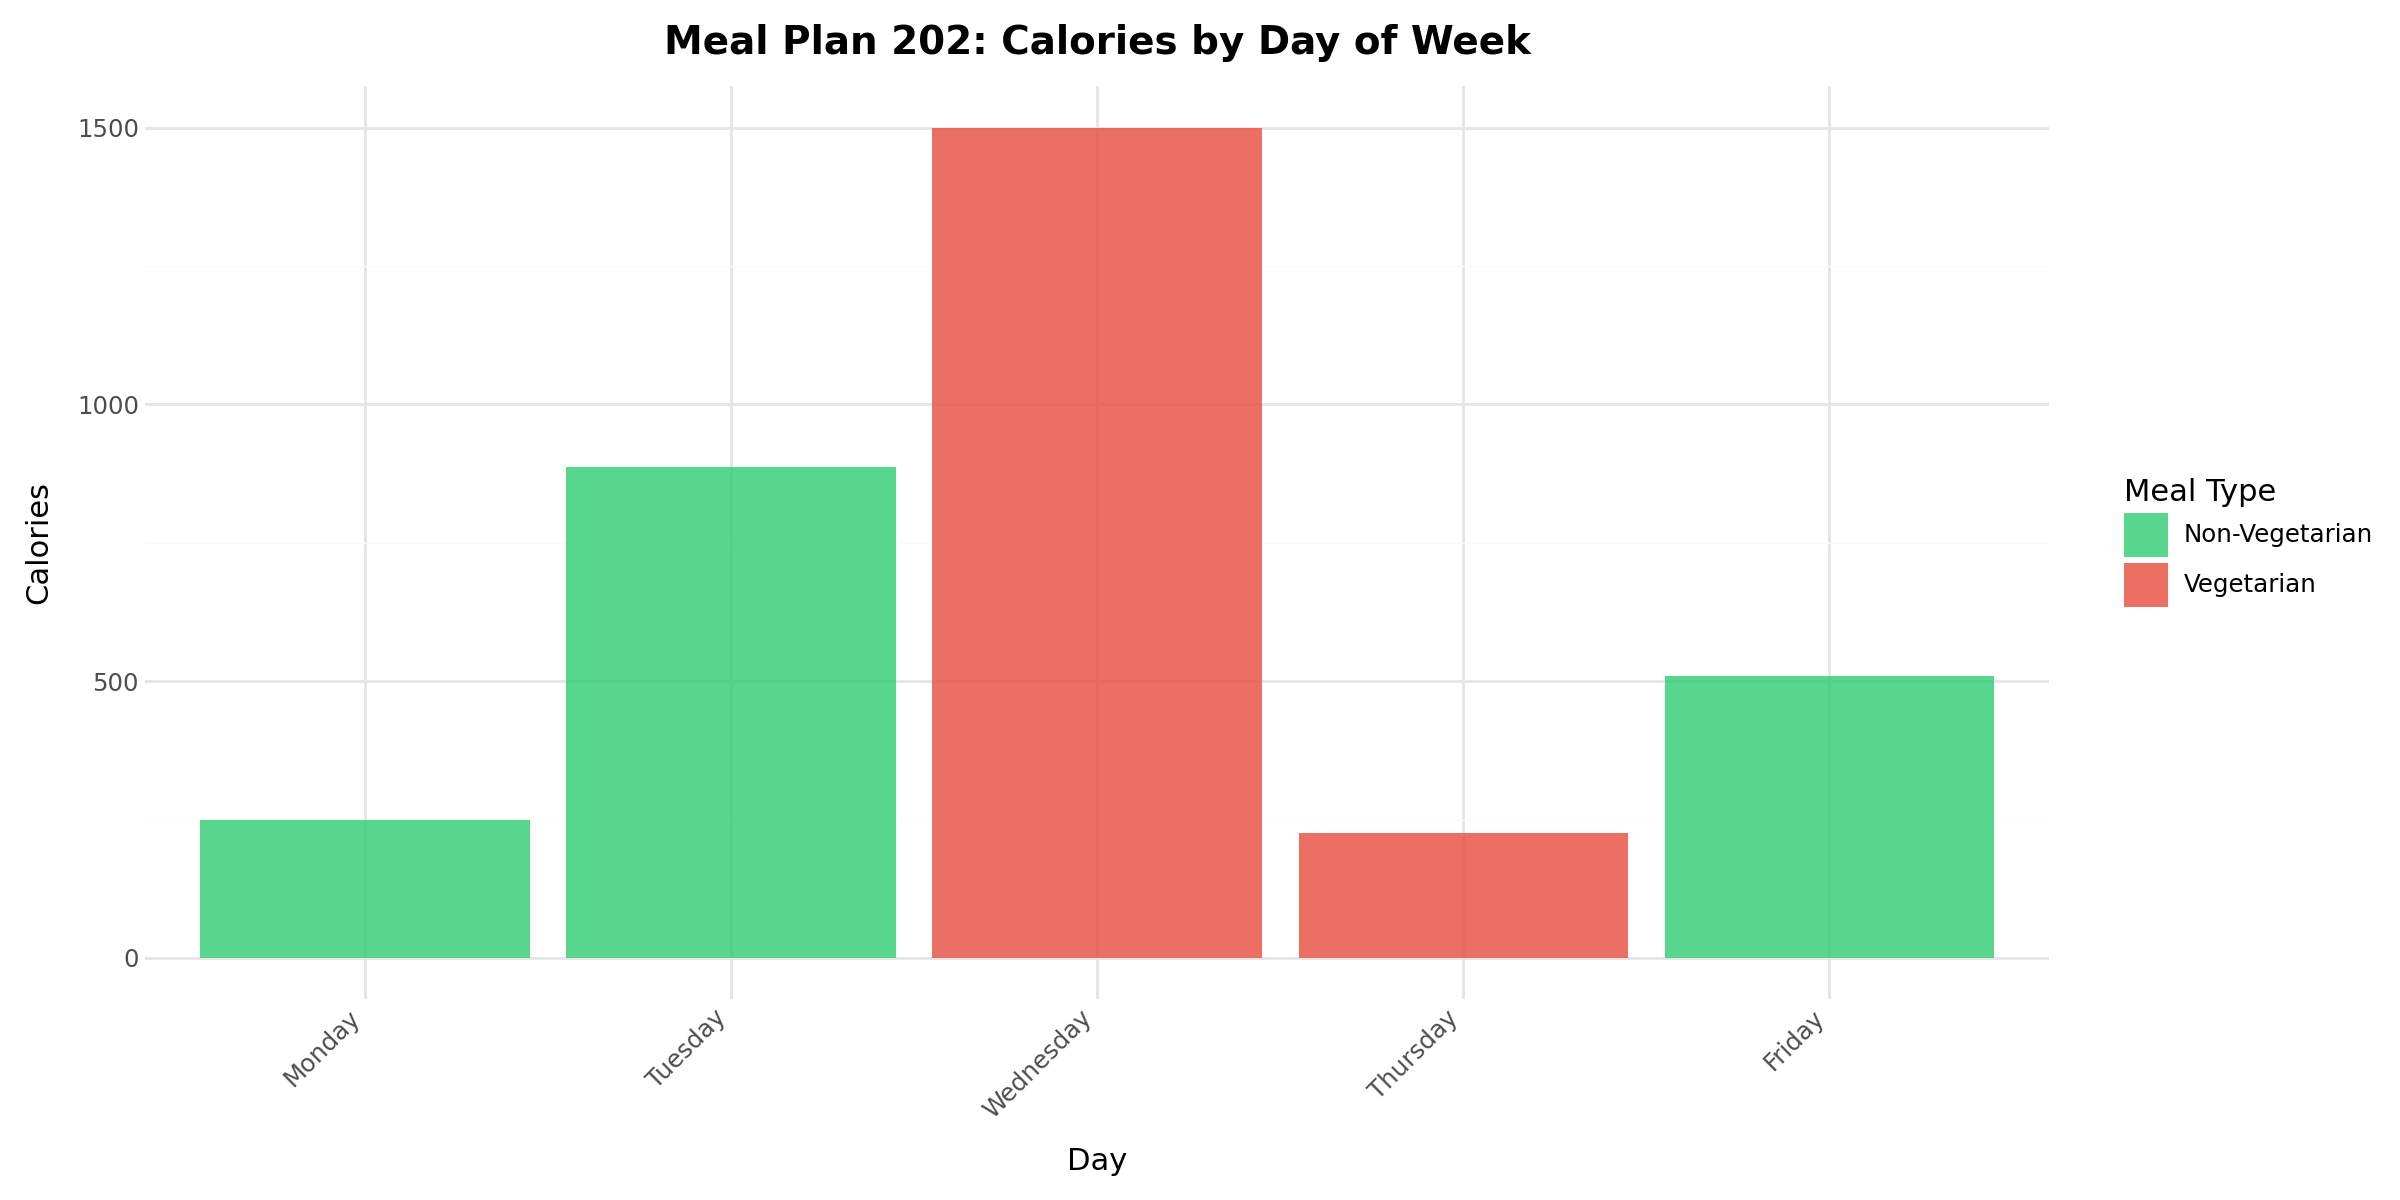

In [44]:
plot1 = (
    ggplot(df_weekly, aes(x='Day of the Week', y='Calories', fill='Meal Type')) +
    geom_col(alpha=0.8) +
    scale_fill_manual(values=['#2ecc71', '#e74c3c']) +
    labs(
        title='Meal Plan 202: Calories by Day of Week',
        x='Day',
        y='Calories',
        fill='Meal Type'
    ) +
    theme_minimal() +
    theme(
        figure_size=(12, 6),
        plot_title=element_text(size=14, weight='bold'),
        axis_text_x=element_text(rotation=45, hjust=1)
    )
)

plot1.show()

This visualization shows the calorie content of each meal across the week for Meal Plan 202. As shown in the graph, Wednesday's Stuffed Shells is the highest-calorie meal at 1500 calories (vegetarian), while Thursday's Vegetarian Stuffed Peppers is the lightest at 226 calories. The legend illustrates the color code, which distinguishes vegetarian meals (red) from non-vegetarian meals (green). The visualization clearly shows that the Meal Plan 202 includes 2 vegetarian days and 3 non-vegetarian days.

Plot 2: Protein Content by Day

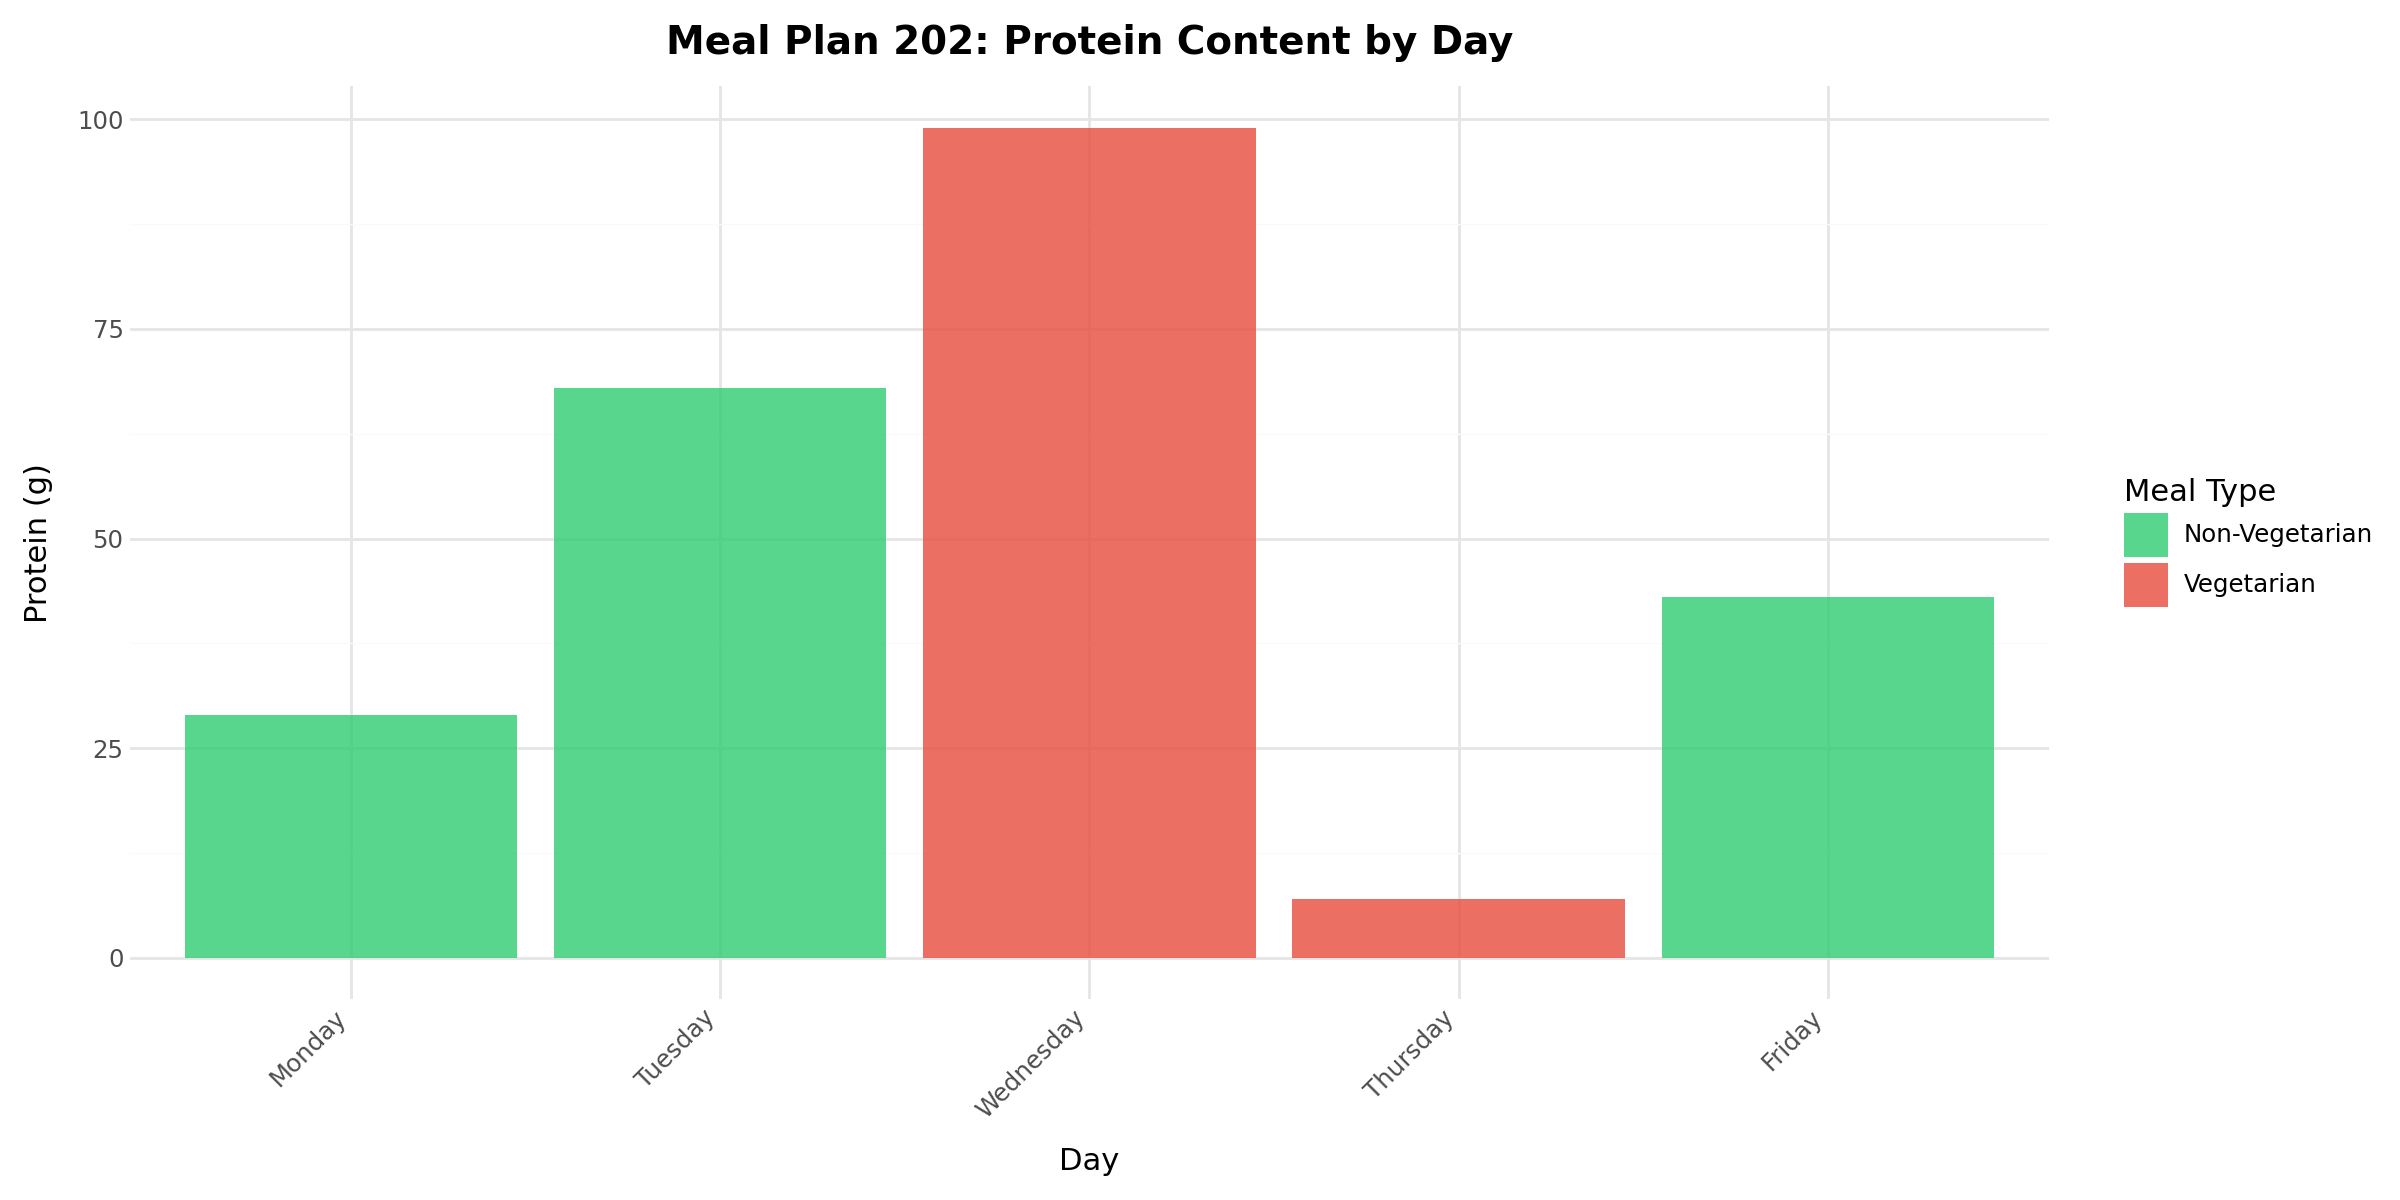

In [45]:
plot2 = (
    ggplot(df_weekly, aes(x='Day of the Week', y='Protein_g', fill='Meal Type')) +
    geom_col(alpha=0.8) +
    scale_fill_manual(values=['#2ecc71', '#e74c3c']) +
    labs(
        title='Meal Plan 202: Protein Content by Day',
        x='Day',
        y='Protein (g)',
        fill='Meal Type'
    ) +
    theme_minimal() +
    theme(
        figure_size=(12, 6),
        plot_title=element_text(size=14, weight='bold'),
        axis_text_x=element_text(rotation=45, hjust=1)
    )
)

plot2.show()

Plot 2 demonstrates protein levels per day, highlighting nutritional differences between meal types. Like Plot 1, it distinguishes between vegetarian and non-vegetarian meals. Wednesday's vegetarian Stuffed Shells has the highest amount of protein, while Thursday's vegetarian Stuffed Peppers has the least amount with only 7g of protein. Following Stuffed Shells with 99g of protein, the next leading protein meal is Tuesday's Beef Noodle Soup with 68g of protein. Since the vegetarian options have the highest protein (Stuffed Shells) and the least protein (Stuffed Peppers), it shows the protein variability within vegetarian options.

Plot 3: Nutritional Comparison (Vegetarian vs Non-Vegetarian)

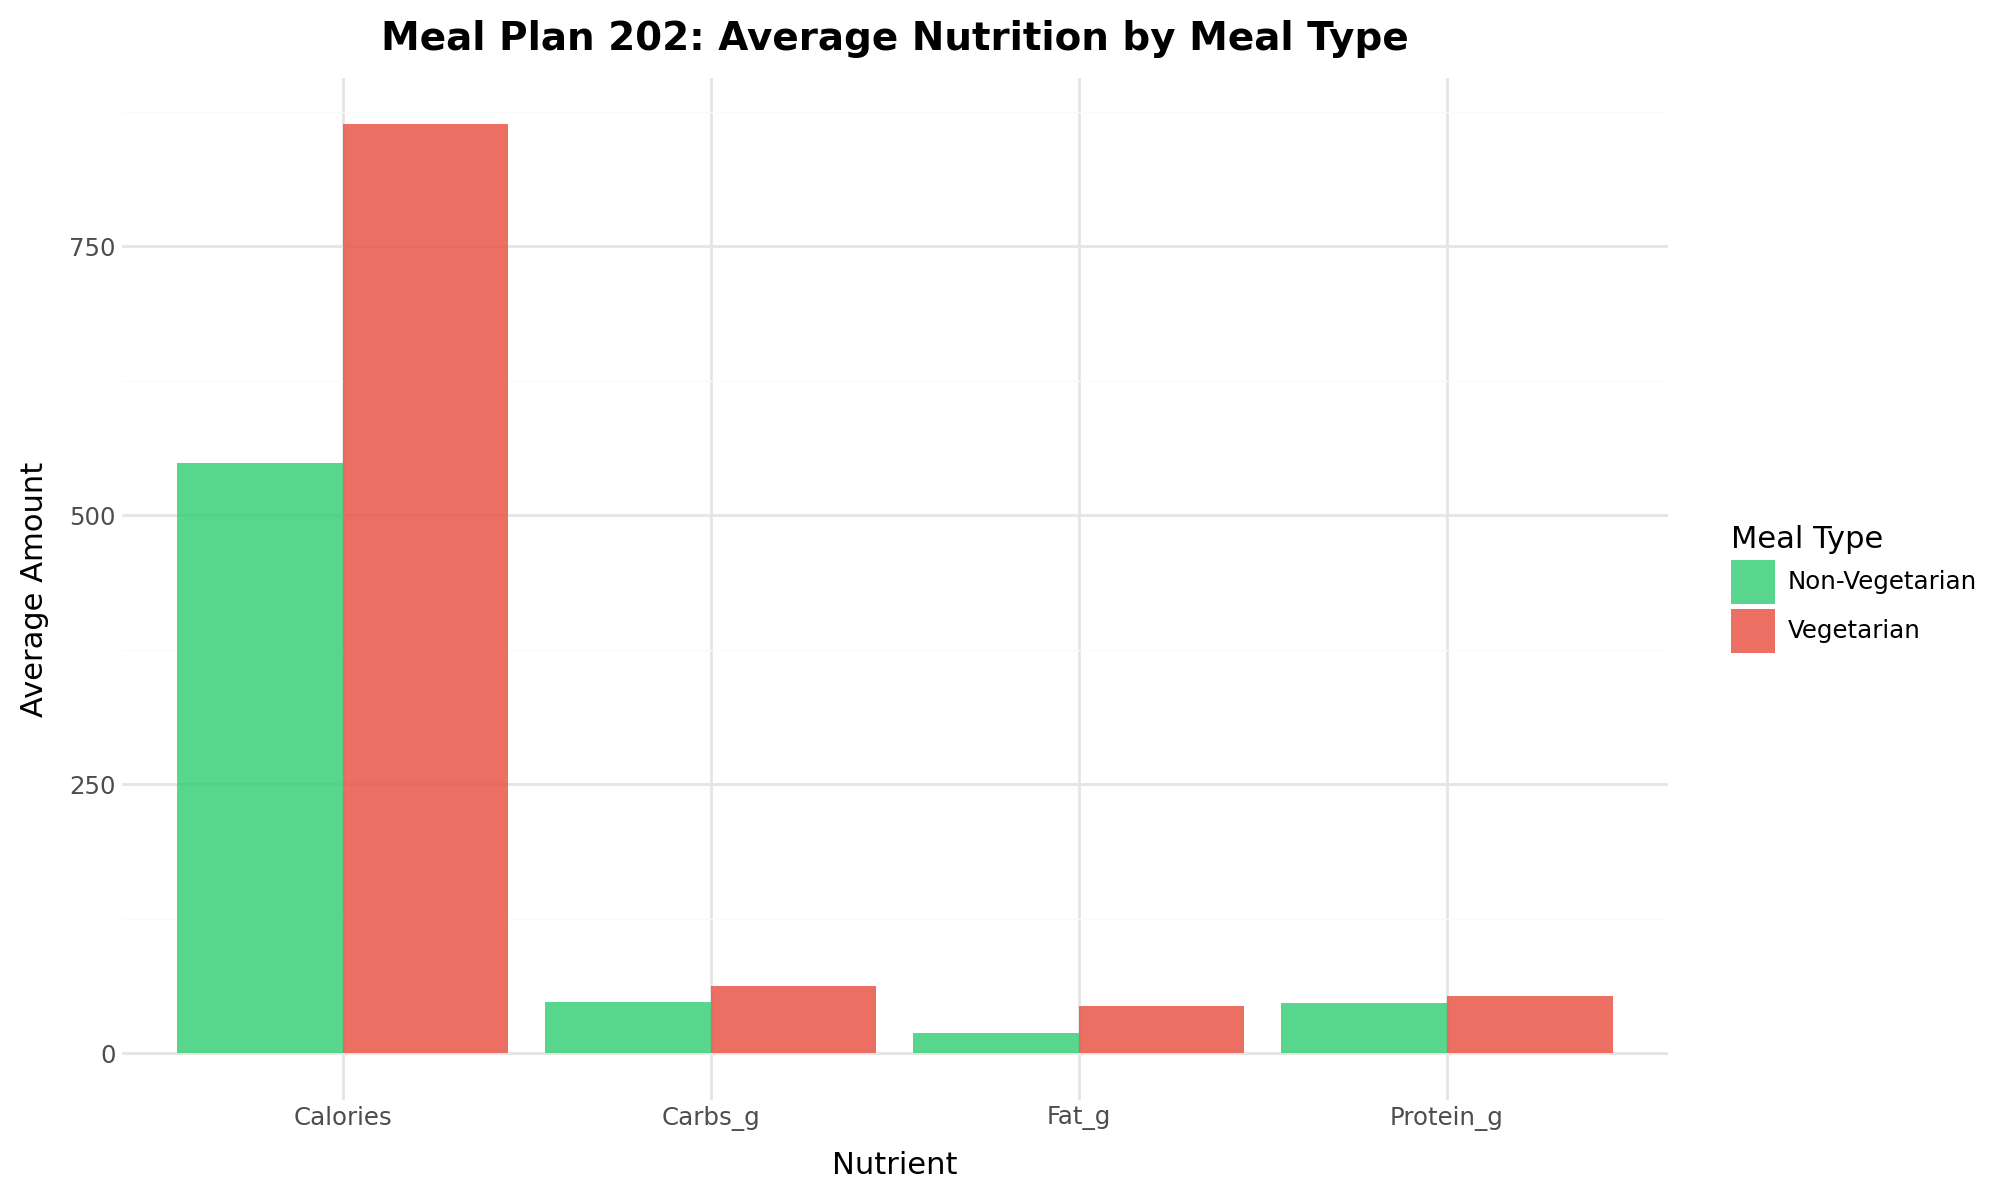

In [ ]:
df_avg = df_weekly.groupby('Meal Type')[['Calories', 'Protein_g', 'Fat_g', 'Carbs_g']].mean().reset_index()
df_avg_long = df_avg.melt(id_vars='Meal Type', var_name='Nutrient', value_name='Average')

plot3 = (
    ggplot(df_avg_long, aes(x='Nutrient', y='Average', fill='Meal Type')) +
    geom_col(position='dodge', alpha=0.8) +
    scale_fill_manual(values=['#2ecc71', '#e74c3c']) +
    labs(
        title='Meal Plan 202: Average Nutrition by Meal Type',
        x='Nutrient',
        y='Average Amount',
        fill='Meal Type'
    ) +
    theme_minimal() +
    theme(
        figure_size=(10, 6),
        plot_title=element_text(size=14, weight='bold')
    )
)

plot3.show()

The chart above illustrates the average nutrition for vegetarian vs non-vegetarian meals. Surprisingly, vegetarian meals have higher calories as opposed to non-vegetarian meals. Vegetarian meals are also higher in carbs, fat, and protein in this specific meal plan; however, the differences are not as drastic as the caloric differences between vegetarian and non-vegetarian meals.

Summary Statistics

In [57]:
print("\n" + "="*70)
print("NUTRITION SUMMARY - MEAL PLAN 202")
print("="*70)
print(f"Average calories per meal: {df_weekly['Calories'].mean():.0f}")
print(f"Average protein per meal: {df_weekly['Protein_g'].mean():.0f}g")
print(f"Average fat per meal: {df_weekly['Fat_g'].mean():.0f}g")
print(f"Average carbs per meal: {df_weekly['Carbs_g'].mean():.0f}g")
print()
if not df_weekly['Calories'].isna().all():
    print(f"Highest calorie meal: {df_weekly.loc[df_weekly['Calories'].idxmax(), 'Mealplan Recipe']} ({df_weekly['Calories'].max():.0f} cal)")
    print(f"Highest protein meal: {df_weekly.loc[df_weekly['Protein_g'].idxmax(), 'Mealplan Recipe']} ({df_weekly['Protein_g'].max():.0f}g)")
print()
print(f"Vegetarian meals: {df_weekly['Vegetarian'].sum()} out of 5")
print(f"Non-vegetarian meals: {(~df_weekly['Vegetarian']).sum()} out of 5")


NUTRITION SUMMARY - MEAL PLAN 202
Average calories per meal: 674
Average protein per meal: 49g
Average fat per meal: 29g
Average carbs per meal: 54g

Highest calorie meal: Stuffed Shells (1500 cal)
Highest protein meal: Stuffed Shells (99g)

Vegetarian meals: 2 out of 5
Non-vegetarian meals: 3 out of 5
